This notebook demonstrates the task of image classification, in this case a multi-classification of: reservoir | natural waterbody | shadows. The notebook includes the fine-tuning (training phase and testing) and inference on a dataset of satellite images containing waterbodies in Angola. General information: 

<br>

| Model | Storage (datasets + model) | Environment |
| ---------------------------------- | ---------------------------------- | ---------------------------------- |
| CNN (EfficientNetv2) | Google Drive | Google Colab (External GPU + mounted to Google Drive)

<br>

The notebook follows these steps:

1.   General setup of DL environment in Google Colab (coupled to your Google Drive)
2.   All settings
3.   Fine-tuning <br>
    3.1 Training the model <br>
    3.2 Testing the fine-tuned model
4.   Inference: classification of waterbodies

# 1. General setup

In [ ]:
# !pip install --upgrade geopandas

# Imports
import pathlib
import numpy as np
import os
import sys
import datetime
import itertools
import tensorflow_hub as hub
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import geopandas as gpd
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# The following line of code is a shell command executed within the notebook. It uses the '!' prefix to run a command as if it were in the terminal.
!nvidia-smi

# The 'nvidia-smi' command stands for NVIDIA System Management Interface. It is used to query and manage NVIDIA GPU devices.
# Running this command displays information about the GPUs on your system, including utilization, memory usage, driver version, and more.

Thu Jul 18 14:30:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Mount Google Drive to access the necessary scripts (consent to everything to get it working)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the AUTOTUNE option for automatic optimization and print the Tensorflow version
AUTO = tf.data.experimental.AUTOTUNE
print(f"Tensorflow version that is currently being used: {tf.__version__}")

Tensorflow version that is currently being used: 2.15.0


In [ ]:
# Initialize TPU if data is stored in the cloud
tpu = None

if tpu:
  # If TPU is initialized, shut down the TPU system
  tf.tpu.experimental.shutdown_tpu_system(tpu)

try:
  # Attempt to detect and initialize a TPU
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
  # If no TPU is found, fall back to default strategy for CPU or single GPU
  strategy = tf.distribute.get_strategy() # default strategy for CPU and single GPU

# 2. Settings

#### Paths and files

In [ ]:
# Google Drive directory that stores the downloaded data and scripts (later change to name repository folder: image_classification)
dir_gdrive = r'/content/drive/MyDrive/AngolaTrainingData'

# Datasets, model and scripts
dir_data = f'{dir_gdrive}/00_data'    #Change to cloud option
dir_model = f'{dir_gdrive}/01_model'  #Change to cloud option
dir_scripts = f'{dir_gdrive}/02_src'
sys.path.append(dir_scripts)

# Coordinates of waterbodies
filename_geojson = 'blobdetected_angola_blobs_filtered_full'  #Change to cloud option

# Print system path
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/AngolaTrainingData/02_src',
 '/content/drive/MyDrive/AngolaTrainingData/02_src']

#### Model (pre-trained CNN)

In [ ]:
model_name = "efficientnetv2-xl-21k"
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"

#### Training

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1.5 / 255)
do_data_augmentation = True

IMAGE_SIZE = (512, 512) # this is the image shape required for the keras model (or what): so if the images have different shapes (that is the case for the vortex images. TODO: the images need to be reshaped to (512, 512); there is a keras function for this)
BATCH_SIZE = 16         # TODO: check with Antonio: he used batch size 20 for the testing and inference
EPOCHS = 300

drop_out_rate = 0.3
learning_rate = 0.005
momentum = 0.9
label_smoothing = 0.1
metrics = ['accuracy']

# 3. Fine-tune model

## 3.1 Training

In [ ]:
def build_training_dataset(dir_data, subset, image_size, batch_size):
  ds = tf.keras.preprocessing.image_dataset_from_directory( #write: expects data in specific format (folder names)
      dir_data,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      seed=123,
      image_size=image_size,
      batch_size=1)

def augment_data(do_data_augmentation, preprocessing_model):
  if do_data_augmentation:
    preprocessing_model.add(
        tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(
        tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
        tf.keras.layers.RandomFlip(mode="horizontal"))
    preprocessing_model.add(
        tf.keras.layers.RandomFlip(mode="vertical"))
  return preprocessing_model

def plot_training_data(ds, number_of_images):
  ncols = 4
  nrows = number_of_images // ncols + 1
  fig = plt.figure(figsize=(15, 15))
  for images, labels in ds.take(1):
    for i in range(number_of_images):
      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(images[i].numpy())
      plt.title(np.argmax(labels[i].numpy()))
      plt.axis("off")
  return fig

def plot_training_results(hist):
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    for i, x in enumerate(['loss', 'accuracy']):
        axes[i].set_ylabel(f'{x} (training and validation)')
        axes[i].set_xlabel("Training steps")
        axes[i].plot(hist[x])
        axes[i].plot(hist[f'val_{x}'])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,2])
    return fig

def save_model(model, dir_model, name_model, hist):
    full_path_model = os.path.join(dir_model, f'model_{name_model}_finetuned.h5')
    model.save(full_path_model)
    hist_df = pd.Dataframe(hist)
    hist_df.to_csv(os.path.join(dir_model, f'hist_{name_model}_finetuned.csv'))
    return  print(f'Your fine-tuned model is saved as: {full_path_model}')

### Build dataset

In [ ]:
# Training data
# dir_data_training = os.path.join(dir_data, 'training')
dir_data_training = f'{dir_gdrive}/AngolaFullTraining'
ds_train_r, class_names, ds_train_size = build_training_dataset(dir_data_training, "training", IMAGE_SIZE, BATCH_SIZE)
preprocessing_model = tf.keras.Sequential([normalization_layer])
preprocessing_model = augment_data(do_data_augmentation, preprocessing_model)
ds_train = ds_train_r.map(lambda images, labels:(preprocessing_model(images), labels))

# Validation data
ds_val, class_names, ds_val_size = build_training_dataset(dir_data_training, "validation", IMAGE_SIZE, BATCH_SIZE)
ds_val = ds_val.map(lambda images, labels:(normalization_layer(images), labels))

Found 382 files belonging to 3 classes.
Using 306 files for training.
Found 382 files belonging to 3 classes.
Using 76 files for validation.


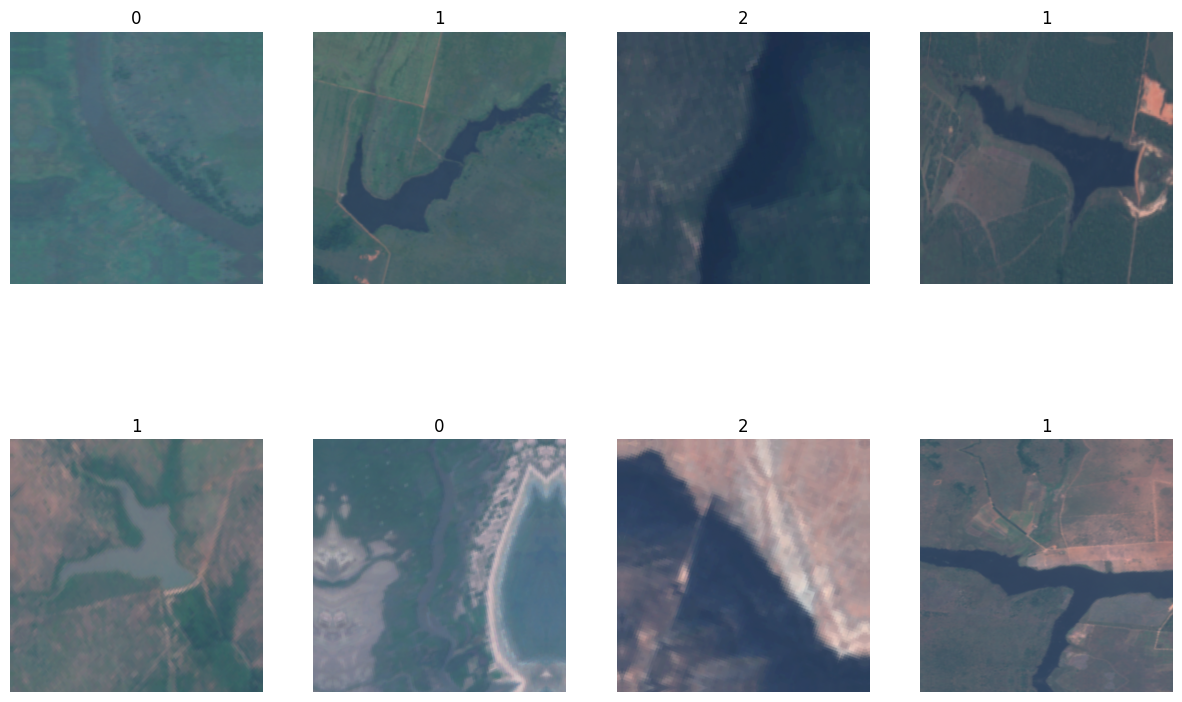

In [ ]:
from dataset import plot_training_data

# Plot a few images from the training dataset to check
fig_train = plot_training_data(ds_train, 8)

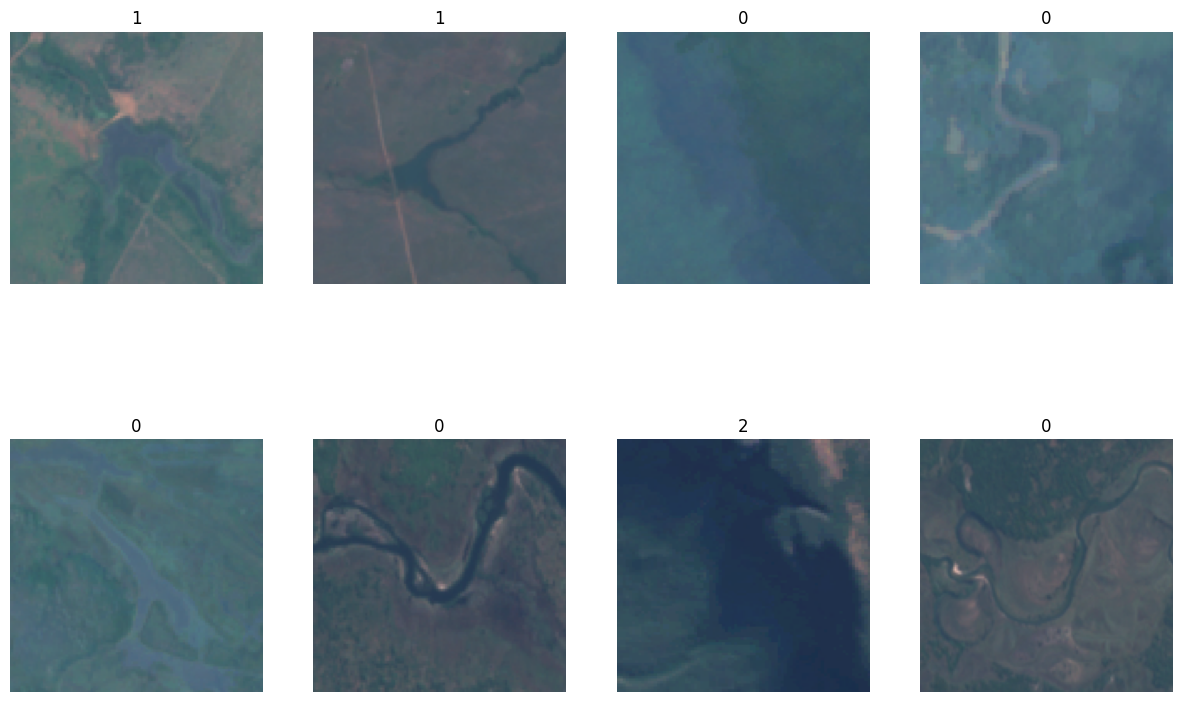

In [ ]:
# Plot a few images from the validation dataset to check
fig_val = plot_training_data(ds_val, 8)

### Build model

In [ ]:
# Composition of the model of different layers (input layer, original encoder layers, dense layers that are trained with the satellite imagery dataset)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=False),
    tf.keras.layers.Dropout(rate=drop_out_rate),
    tf.keras.layers.Dense(len(class_names),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

# Configure the model for training by specifiying the optimizer (Stochastic Gradient Descent), loss function and metrics to be used
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=label_smoothing),
  metrics=metrics)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 207619675 (792.01 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 207615832 (791.99 MB)
_________________________________________________________________


### Train model

In [ ]:
# Actual training of the dense layers in the sequenced model
hist = model.fit(
    ds_train,
    epochs=EPOCHS,
    callbacks=[callback],
    steps_per_epoch=ds_train_size // BATCH_SIZE,
    validation_data=ds_val,
    validation_steps=ds_val_size // BATCH_SIZE).history


Epoch 1/300
19/19 [==============================] - 45s 2s/step - loss: 0.9763 - accuracy: 0.7862 - val_loss: 1.6418 - val_accuracy: 0.7500
Epoch 2/300
19/19 [==============================] - 43s 2s/step - loss: 0.8638 - accuracy: 0.8517 - val_loss: 0.8349 - val_accuracy: 0.8906
Epoch 3/300
19/19 [==============================] - 40s 2s/step - loss: 0.9321 - accuracy: 0.8172 - val_loss: 1.0251 - val_accuracy: 0.8281
Epoch 4/300
19/19 [==============================] - 39s 2s/step - loss: 0.8148 - accuracy: 0.8138 - val_loss: 0.7082 - val_accuracy: 0.9062
Epoch 4: early stopping


In [ ]:
# Plot results of the training
fig = plot_training_results(hist)

In [ ]:
# Save the fine-tuned model (and its history object) to use for inference
save_model(model, dir_model, model_name, hist)

## 3.2 Testing

In [ ]:
def test_model(model, ds):
    labels_test = []
    predictions_test = []
    for images, labels in ds:
        batch_predictions = model.predict(images)
        labels_test.extend(labels)
        predictions_test.extend(np.argmax(batch_predictions, axis=1))
    return labels_test, predictions_test


def plot_test_results(model, ds):
    fig = plt.figure(figsize=(15, 15))
    for images, labels in ds.take(1):
        y_pred = model.predict(images)
        y_pred_binary = np.argmax(y_pred, axis = 1)
        for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy())
            plt.title('label:{}, pred:{}'.format(int(labels[i]), y_pred_binary[i]))
            plt.axis("off")
    return fig

### Build dataset

In [ ]:
dir_data_testing = os.path.join(dir_data, 'testing') # dir_data_testing = f'{dir_gdrive}/testing3class'

ds_test = tf.keras.utils.image_dataset_from_directory(
    dir_data_testing,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, #25?
    shuffle = True
)

ds_test = ds_test.map(lambda images, labels:(normalization_layer(images), labels))

### Test model

In [ ]:
# Load fine-tuned model
model = keras.models.load_model(os.path.join(dir_model, f'{model_name}_finetuned.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer})
# model = keras.models.load_model(r'/content/drive/MyDrive/AngolaTrainingData/model_EffNetV2_retrainedAngola_3class.h5',
#        custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

labels_test, predictions_test = test_model(model, ds_test)

acc = accuracy_score(labels_test, predictions_test)
cm = confusion_matrix(labels_test, predictions_test)

print(f"Accuracy: {acc}")
print(f"Confusion matrix: \n{cm}")

In [ ]:
fig = plot_test_results(model, ds_test)

# 4. Inference

In [ ]:
def get_img_ids(ds):
   file_names = [os.path.basename(name) for name in ds.file_paths]
   img_ids = np.array([line.split('_')[1].split('.')[0] for line in file_names])
   return img_ids


def link_waterbodies_coordinates(img_ids, y_pred, data_coord):
    data_coord['id'] = data_coord['id'].astype(str)
    df_img = pd.DataFrame({'id': img_ids.astype(str), 'prediction': y_pred})
    pred_coord = pd.merge(data_coord, df_img, on='id')
    return pred_coord


def save_prediction_geojson(pred_coord, dir_data, filename_geojson):
   full_path_pred_coordinates = os.path.join(dir_data, f'{filename_geojson}_predicted.geojson')
   pred_coord.to_file(full_path_pred_coordinates, driver='GeoJSON')
   return print(f'Your predicitons linked to the coordinates of the waterbodies is saved as: {full_path_pred_coordinates}')


def plot_inference_results(model, ds):
    fig = plt.figure(figsize=(15, 15))
    for images in ds.take(1):
      y_pred = model.predict(images)
      y_pred_binary = np.argmax(y_pred, axis = 1)
      for i in range(20):
          plt.subplot(5, 4, i + 1)
          plt.imshow(images[i].numpy())
          plt.title('pred:{}'.format(y_pred_binary[i]))
          plt.axis("off")
    return fig

### Build dataset

In [ ]:
dir_data_inference = os.path.join(dir_data, 'inference') # dir_data_inference = f'{dir_gdrive}/AngolaPNGsZoom'

ds_inf = tf.keras.utils.image_dataset_from_directory(
    dir_data_inference,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, #20?
    shuffle = False,
    label_mode=None,
    labels=None)

img_ids = get_img_ids(ds_inf)

ds_inf = ds_inf.map(lambda images:(normalization_layer(images)))

### Inference

In [ ]:
predictions = model.predict(ds_inf)
y_pred = np.argmax(predictions, axis = 1)

In [ ]:
# Show some results of the inference
fig = plot_inference_results(model, ds_inf)

In [ ]:
# Link the waterbodies in the images to the coordinates of the blobs in the geojson file and save to a new geojson file
data_coord = gpd.read_file(os.path.join(dir_data, f'{filename_geojson}.geojson'))
pred_coord = link_waterbodies_coordinates(img_ids, y_pred, data_coord)
save_prediction_geojson(pred_coord, dir_data, filename_geojson)